<a href="https://colab.research.google.com/github/jiin124/Introduction-to-NLP-using-deep-learning/blob/main/%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D/6_RNN%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%83%9D%EC%84%B1(Text_Generation_using_RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. RNN을 이용해 텍스트 생성하기

예를 들어서 '경마장에 있는 말이 뛰고 있다'와 '그의 말이 법이다'와 '가는 말이 고와야 오는 말이 곱다'라는 세 가지 문장이 있다고 해봅시다. 모델이 문맥을 학습할 수 있도록 전체 문장의 앞의 단어들을 전부 고려하여 학습하도록 데이터를 재구성한다면 아래와 같이 총 11개의 샘플이 구성됩니다.

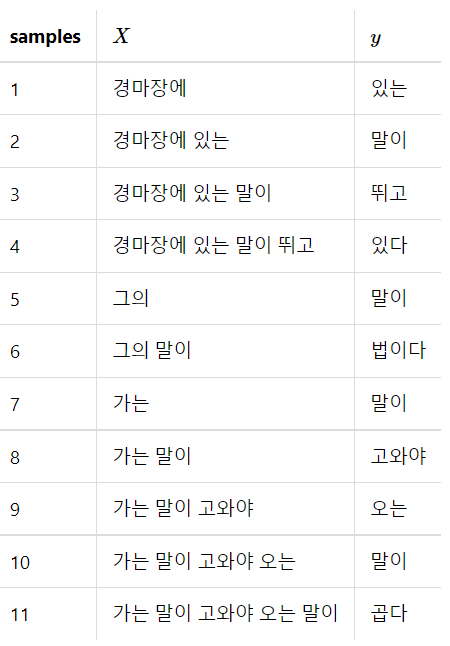

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [2]:
text="""경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

단어집합 생성, 정수 인덱스

In [3]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size=len(tokenizer.word_index)+1#패딩을 위한 0을 고려해 +1해주기
print('단어집합의 크기 : %d'%vocab_size)

단어집합의 크기 : 12


In [4]:
print(tokenizer.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [8]:
#훈련데이터 만들기

sequences=list()

for line in text.split('\n'):
  encoded=tokenizer.texts_to_sequences([line])[0]
  #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환합니다.
  for i in range(1,len(encoded)):
    sequence=encoded[:i+1]
    sequences.append(sequence)

print('학습에 사용할 샘플의 개수 : %d'%len(sequences))

학습에 사용할 샘플의 개수 : 11


In [9]:
print(sequences)

[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


우선 전체 샘플에 대해서 길이를 일치시켜 줍니다. 가장 긴 샘플의 길이를 기준으로 합니다. 현재 육안으로 봤을 때, 길이가 가장 긴 샘플은 [8, 1, 9, 10, 1, 11]이고 길이는 6입니다. 이를 코드로는 다음과 같이 구할 수 있습니다.

In [11]:
max_len=max(len(l) for l in sequences)
print('샘플의 최대 길이 :{}'.format(max_len))

샘플의 최대 길이 :6


In [12]:
#전체 샘플의 길이를 6으로 패딩
sequences=pad_sequences(sequences,maxlen=max_len,padding='pre')

pad_sequences()는 모든 샘플에 대해서 0을 사용하여 길이를 맞춰줍니다. maxlen의 값으로 6을 주면 모든 샘플의 길이를 6으로 맞춰주며, padding의 인자로 'pre'를 주면 길이가 6보다 짧은 샘플의 앞에 0으로 채웁니다. 전체 훈련 데이터를 출력해봅니다.

In [13]:
print(sequences)

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


각 샘플의 마지막 단어를 레이블로 분리, 레이블의 분리는 Numpy를 이용해 가능하다. 리스트의 마지막값을 제외하고 저장한 것은 x,리스트의 마지막 값 만 저장한 것은 y,이는 레이블에 해당된다. 

In [15]:
sequences=np.array(sequences)
X=sequences[:,:-1]
y=sequences[:,-1]

In [16]:
print(X)

[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]


In [17]:
print(y)

[ 3  1  4  5  1  7  1  9 10  1 11]


RNN 모델에 훈련 데이터를 훈련시키기 전에 레이블에 대해서 원핫 인코딩을 수행

In [18]:
y=to_categorical(y,num_classes=vocab_size)

In [19]:
print(y)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 2) 모델 설계하기

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,SimpleRNN

하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉상태의 크기는 32이다. 다 대 일 구조의 RNN을 사용한다. 전결합층을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계한다. 해당 모델은 마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제를 수행하는 모델이다. 다중 클래스 분류 문제의 경우 출력층에 소프트 맥스 회귀를 사용해야하므로 활성화 함수로는 소프트 맥스 함수를 사용하고, 손실함수로 크로스 엔트로피함수를 사용해 200에포크를 수행한다. 

In [21]:
embedding_dim=10
hidden_units=32

model=Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X,y,epochs=200,verbose=2)

Epoch 1/200
1/1 - 1s - loss: 2.4662 - accuracy: 0.0000e+00 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 2.4509 - accuracy: 0.1818 - 4ms/epoch - 4ms/step
Epoch 3/200
1/1 - 0s - loss: 2.4357 - accuracy: 0.3636 - 4ms/epoch - 4ms/step
Epoch 4/200
1/1 - 0s - loss: 2.4204 - accuracy: 0.4545 - 6ms/epoch - 6ms/step
Epoch 5/200
1/1 - 0s - loss: 2.4049 - accuracy: 0.3636 - 9ms/epoch - 9ms/step
Epoch 6/200
1/1 - 0s - loss: 2.3891 - accuracy: 0.4545 - 6ms/epoch - 6ms/step
Epoch 7/200
1/1 - 0s - loss: 2.3728 - accuracy: 0.4545 - 6ms/epoch - 6ms/step
Epoch 8/200
1/1 - 0s - loss: 2.3559 - accuracy: 0.4545 - 6ms/epoch - 6ms/step
Epoch 9/200
1/1 - 0s - loss: 2.3385 - accuracy: 0.4545 - 5ms/epoch - 5ms/step
Epoch 10/200
1/1 - 0s - loss: 2.3203 - accuracy: 0.4545 - 5ms/epoch - 5ms/step
Epoch 11/200
1/1 - 0s - loss: 2.3013 - accuracy: 0.4545 - 5ms/epoch - 5ms/step
Epoch 12/200
1/1 - 0s - loss: 2.2814 - accuracy: 0.4545 - 4ms/epoch - 4ms/step
Epoch 13/200
1/1 - 0s - loss: 2.2607 - accuracy: 0.4545 - 7

In [22]:
#모델이 정확하게 예측하고 있는지 문장을 생성해주는 함수

def sentence_generation(model,tokenizer,current_word,n):
  init_word=current_word
  sentence=''

  #n번반복
  for _ in range(n):
    #현재 단어에 대한 정수 인코딩과 패딩
    encoded=tokenizer.texts_to_sequences([current_word])[0]
    encoded=pad_sequences([encoded],maxlen=5,padding='pre')
    #입력한X에 대해서 Y를 예측하고 Y를 result에 저장.
    result=model.predict(encoded,verbose=0)
    result=np.argmax(result,axis=1)

    for word,index in tokenizer.word_index.items():
      #만약 예측한 단어와 인덱스와 동일한 단어가 있다면 break
      if index==result:
        break

    # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
    current_word=current_word+' '+word

    #예측단어를 문장에 저장
    sentence=sentence+' '+word

  sentence=init_word+sentence
  return sentence


In [23]:
print(sentence_generation(model, tokenizer, '경마장에', 4))

경마장에 있는 말이 뛰고 있다


In [24]:
print(sentence_generation(model, tokenizer, '그의', 2))

그의 말이 법이다


In [25]:
print(sentence_generation(model, tokenizer, '가는', 5))

가는 말이 고와야 오는 말이 곱다


# 2. LSTM으로 텍스트 생성

In [26]:
import os

os.environ['KAGGLE_USERNAME']='jiinpp'
os.environ['KAGGLE_KEY']="b06d525a9f66198051ccb648b091778a"

!kaggle datasets download -d aashita/nyt-comments

100% 480M/480M [00:03<00:00, 110MB/s] 



In [27]:
!unzip '*.zip'

Archive:  nyt-comments.zip
  inflating: ArticlesApril2017.csv   
  inflating: ArticlesApril2018.csv   
  inflating: ArticlesFeb2017.csv     
  inflating: ArticlesFeb2018.csv     
  inflating: ArticlesJan2017.csv     
  inflating: ArticlesJan2018.csv     
  inflating: ArticlesMarch2017.csv   
  inflating: ArticlesMarch2018.csv   
  inflating: ArticlesMay2017.csv     
  inflating: CommentsApril2017.csv   
  inflating: CommentsApril2018.csv   
  inflating: CommentsFeb2017.csv     
  inflating: CommentsFeb2018.csv     
  inflating: CommentsJan2017.csv     
  inflating: CommentsJan2018.csv     
  inflating: CommentsMarch2017.csv   
  inflating: CommentsMarch2018.csv   
  inflating: CommentsMay2017.csv     


In [28]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [29]:
df = pd.read_csv('ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [30]:
print(len(df.columns))
print(df.columns)


15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


여기서 사용할 열은 제목에 해당되는 headline열이다. NULL갑싱 있는지 확인해보자

In [32]:
df['headline'].isna().sum()

0

headline열에서 모든 신문기사의 제목을 뽀아서 하나의 리스트로 저장해보자

In [33]:
headline=[]
headline.extend(list(df.headline.values))
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

네번째와 다섯 번째 샘플에 Unknown 값이 들어가있습니다. headline 전체에 걸쳐서 Unknown 값을 가진 샘플이 있을 것으로 추정됩니다. 비록 Null 값은 아니지만 실습에 도움이 되지 않는 노이즈 데이터이므로 제거해줄 필요가 있습니다. 제거하기 전에 현재 샘플의 개수를 확인해보고 제거 전, 후의 샘플의 개수를 비교해봅시다.

In [34]:
print('총 샘플의 개수 : {}'.format(len(headline)))

총 샘플의 개수 : 1324


In [35]:
headline=[word for word in headline if word!='Unknown']
print('노이즈 값 제거 후 샘플의 개수 :{}'.format(len(headline)))

노이즈 값 제거 후 샘플의 개수 :1214


In [36]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

구두점 제거, 단어의 소문자화

In [37]:
def repreprocessing(raw_sentence):
  preprocessed_sentence=raw_sentence.encode('utf8').decode('ascii','ignore')
  #구두점 제거와 동시에 소문자화
  return ''.join(word for word in preprocessed_sentence if word not in punctuation).lower()

preprocessed_headline=[repreprocessing(x) for x in headline]
preprocessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [39]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(preprocessed_headline)
vocab_size=len(tokenizer.word_index)+1
print('단어 집합의 크기 : %d'%vocab_size)

단어 집합의 크기 : 3494


In [40]:
sequences=list()

for sentence in preprocessed_headline:

  #각샘플에 대한 정수 인코딩
  encoded=tokenizer.texts_to_sequences([sentence])[0]
  for i in range(1,len(encoded)):
    sequence=encoded[:i+1]
    sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]



```
[[99, 269], # former nfl
 [99, 269, 371], # former nfl cheerleaders
 [99, 269, 371, 1115], # former nfl cheerleaders settlement
 [99, 269, 371, 1115, 582], # former nfl cheerleaders settlement offer
 [99, 269, 371, 1115, 582, 52], # 'former nfl cheerleaders settlement offer 1
 [99, 269, 371, 1115, 582, 52, 7], # former nfl cheerleaders settlement offer 1 and
 [99, 269, 371, 1115, 582, 52, 7, 2], # ... 이하 생략 ...
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116], # 모든 단어가 사용된 완전한 첫번째 문장
 # 바로 위의 줄은 : former nfl cheerleaders settlement offer 1 and a meeting with goodell
 [100, 3]] # epa to에 해당되며 두번째 문장이 시작됨.
```



이해를 돕기 위해 출력 결과에 주석을 추가하였습니다. 왜 하나의 문장을 저렇게 나눌까요? 예를 들어 '경마장에 있는 말이 뛰고 있다' 라는 문장 하나가 있을 때, 최종적으로 원하는 훈련 데이터의 형태는 다음과 같습니다. 하나의 단어를 예측하기 위해 이전에 등장한 단어들을 모두 참고하는 것입니다.

In [43]:
index_to_word={}
for key,value in tokenizer.word_index.items():# 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
  index_to_word[value]=key

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


In [44]:
max_len=max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


In [45]:
#패딩
sequences=pad_sequences(sequences,maxlen=max_len,padding='pre')
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [46]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [47]:
print(X[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]


In [48]:
print(y[:3])

[ 269  371 1115]


In [51]:
y=to_categorical(y,num_classes=vocab_size)#레이블데이터 y에 대해서 원핫인코딩

## 2) 모델 설게

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

하이퍼파라미터인 임베딩 벡터의 차원은 10, 은닉 상태의 크기는 128입니다. 다 대 일 구조의 LSTM을 사용합니다. 전결합층(Fully Connected Layer)을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계합니다. 해당 모델은 마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 200 에포크를 수행합니다.

In [53]:
embedding_dim=10
hidden_units=128

model=Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X,y,epochs=200,verbose=2)

Epoch 1/200
244/244 - 10s - loss: 7.6520 - accuracy: 0.0293 - 10s/epoch - 41ms/step
Epoch 2/200
244/244 - 8s - loss: 7.1195 - accuracy: 0.0282 - 8s/epoch - 31ms/step
Epoch 3/200
244/244 - 8s - loss: 6.9794 - accuracy: 0.0342 - 8s/epoch - 32ms/step
Epoch 4/200
244/244 - 8s - loss: 6.8549 - accuracy: 0.0410 - 8s/epoch - 32ms/step
Epoch 5/200
244/244 - 8s - loss: 6.7091 - accuracy: 0.0427 - 8s/epoch - 32ms/step
Epoch 6/200
244/244 - 8s - loss: 6.5427 - accuracy: 0.0486 - 8s/epoch - 32ms/step
Epoch 7/200
244/244 - 8s - loss: 6.3554 - accuracy: 0.0507 - 8s/epoch - 32ms/step
Epoch 8/200
244/244 - 8s - loss: 6.1592 - accuracy: 0.0564 - 8s/epoch - 32ms/step
Epoch 9/200
244/244 - 8s - loss: 5.9646 - accuracy: 0.0590 - 8s/epoch - 32ms/step
Epoch 10/200
244/244 - 8s - loss: 5.7697 - accuracy: 0.0648 - 8s/epoch - 32ms/step
Epoch 11/200
244/244 - 8s - loss: 5.5862 - accuracy: 0.0702 - 8s/epoch - 32ms/step
Epoch 12/200
244/244 - 8s - loss: 5.4132 - accuracy: 0.0727 - 8s/epoch - 32ms/step
Epoch 13/20

In [54]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items(): 
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

In [55]:
print(sentence_generation(model, tokenizer, 'i', 10))

i want to be rich and im not sorry moves to


In [56]:
print(sentence_generation(model, tokenizer, 'how', 10))

how to make facebook more accountable can the russia investigation may
